In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import re
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import MeanShift, KMeans, SpectralClustering
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, similarities, matutils
from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  

import string
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from utils import display_topics, plot_topic_words, plot_topic_time, topic_wordcloud,\
                    plot_chapter_topics_book, make_stopwords, titles, plot_topic_and_rating

import pickle

In [3]:
sw = make_stopwords()
all_books_nosw_singularized = pd.read_pickle('data/allbooks_sing_nosw.pkl')


## Get model built 

In [16]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),  stop_words=sw, max_df=.95, min_df=2)
doc_word = vectorizer.fit_transform(all_books_nosw_singularized['text'])
nmf_model = NMF(20, max_iter=1000, random_state = 3)
doc_topic = nmf_model.fit_transform(doc_word)

In [17]:
topics = ['Rand', 'Perrin', 'Mat', 'Nynaeve', 'Egwene', 'Moiraine', 'Aiel', 'Gawyn', 'Elayne', 'Seanchan', 'Siuan',
         'Cadsuane politics', 'Black Tower', 'White Tower Politics', 'Horn of Valere', 'Faile/Shaido', 'Min',
         'Last Battle', 'Emond\'s Field','Thom']

display_topics(nmf_model, vectorizer.get_feature_names(), 20, topic_names=topics)


Topic: ' Rand '
rand, therin, lews, lews therin, bashere, dragon, taim, lord, lord dragon, maiden, saidin, weiramon, aiel, city, dashiva, cairhienin, sword, sulin, asmodean, sammael

Topic: ' Perrin '
perrin, faile, wolf, gaul, elyas, slayer, berelain, hopper, galad, masema, aram, byar, aybara, lord, whitecloak, grady, scent, camp, two river, loial

Topic: ' Mat '
mat, talmanes, bloody, noal, thorn, olver, gholam, dice, vanin, nalesean, ashandarei, eelfinn, joline, tylin, band, cauthon, pips, medallion, aludra, going

Topic: ' Nynaeve '
nynaeve, elayne, moghedien, juilin, sedai, aes, aes sedai, liandrin, birgitte, woman, egeanin, nynaeve elayne, telaranrhiod, braid, door, sheriam, saidar, galad, luca, salidar

Topic: ' Egwene '
egwene, amyrlin, sheriam, elaida, tower, verin, silviana, novice, ajah, sitter, meidani, sedai, sister, hall, white tower, white, aes, romanda, shed, aes sedai

Topic: ' Moiraine '
moiraine, lan, rand, sedai, loial, aes, aes sedai, warder, perrin, trolloc, zari

In [18]:
topics_by_chapter = pd.DataFrame(doc_topic, columns = topics )

not_text = ['chapter_title', 'book_title', 'cumulative_chapter_number']
topics_by_chapter = pd.concat([all_books_nosw_singularized[not_text],topics_by_chapter],axis=1)

In [19]:
starts = [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626]
ends = [54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 676]


starts_ends= [0,54, 105, 162, 220, 277, 334, 376, 408, 444, 476, 515, 567, 626, 677]

tick_locations = []
for i in range(len(starts_ends)-1):
    ave = (starts_ends[i] + starts_ends[i+1])//2
    tick_locations.append(ave)
tick_locations=np.array(tick_locations)




## Topic visualizations

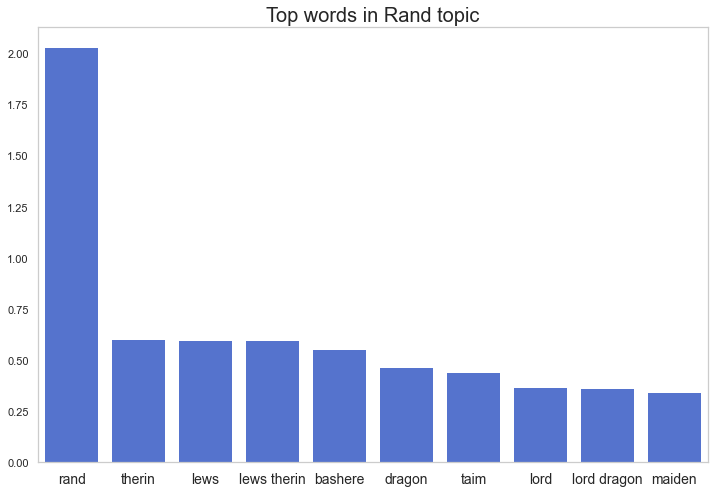

In [90]:
plot_topic_words(nmf_model, vectorizer.get_feature_names(), 0, topics)

In [21]:
with open('saved_models/nmf_model.pkl', 'wb') as f:
    pickle.dump(nmf_model, f)

with open('saved_models/vec_feature_names.pkl', 'wb') as f:
    pickle.dump(vectorizer.get_feature_names(), f)

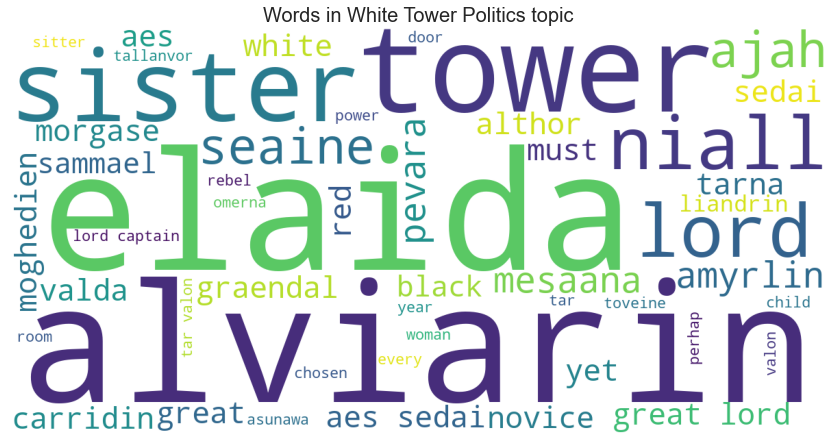

In [89]:
topic_wordcloud(nmf_model, vectorizer.get_feature_names(), 13, topics)

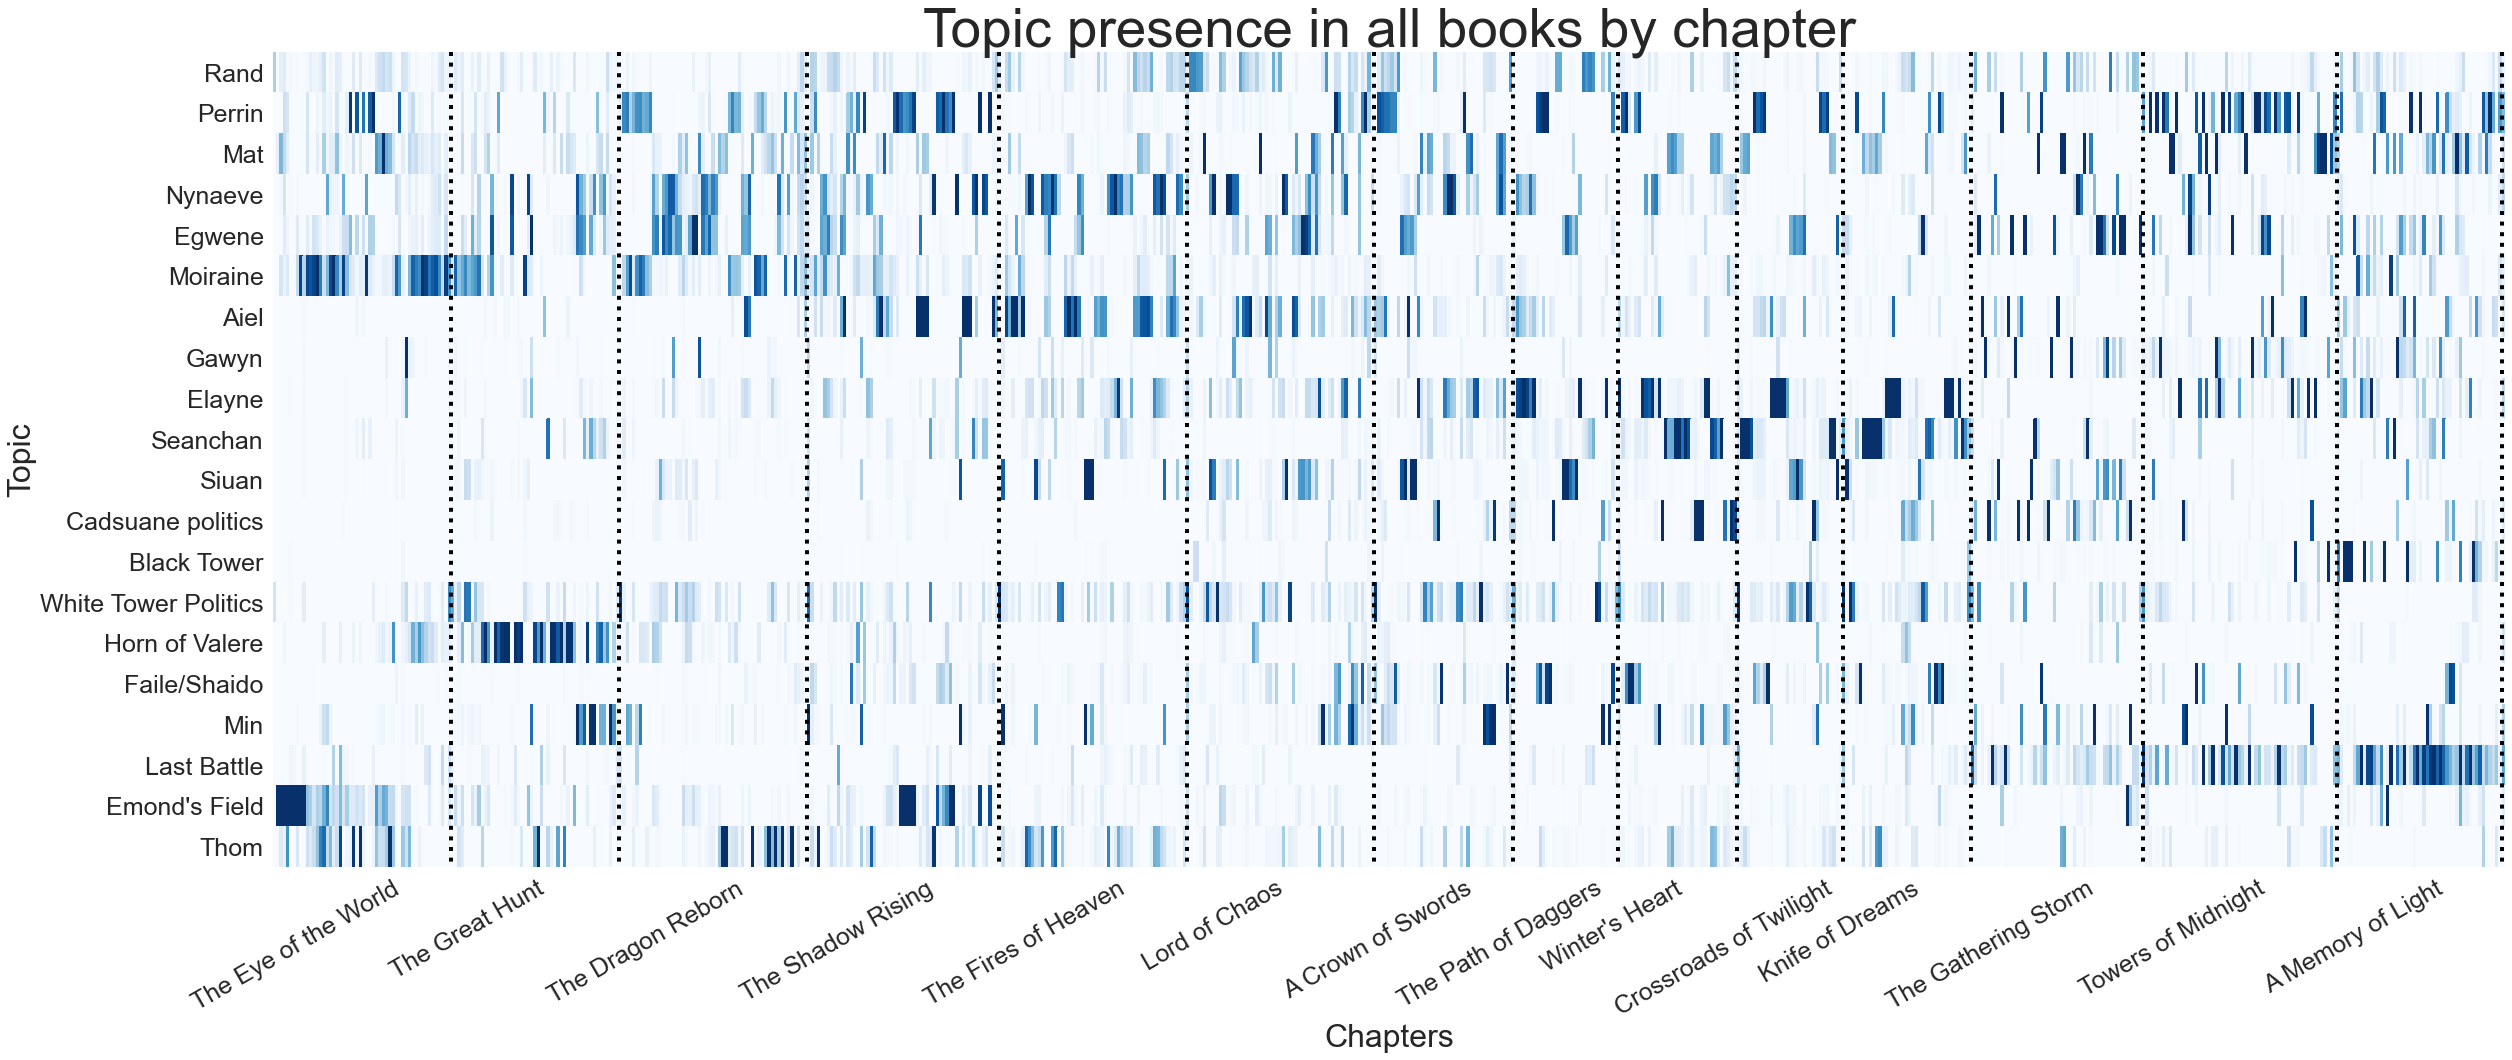

In [23]:
plt.figure(figsize=(40,15))
sns.heatmap(data = topics_by_chapter[topics].T, cmap='Blues', cbar=False, robust=True)
plt.yticks(fontsize=25)
plt.xticks(ticks = tick_locations-20, labels = titles, fontsize = 25, rotation = 30 )
plt.vlines(ends, 0 ,25, color = 'black', linestyles='dotted', linewidths=4)
plt.title('Topic presence in all books by chapter', fontsize = 55)
plt.ylabel('Topic', fontsize = 32)
plt.xlabel('Chapters', fontsize = 32)
plt.show()

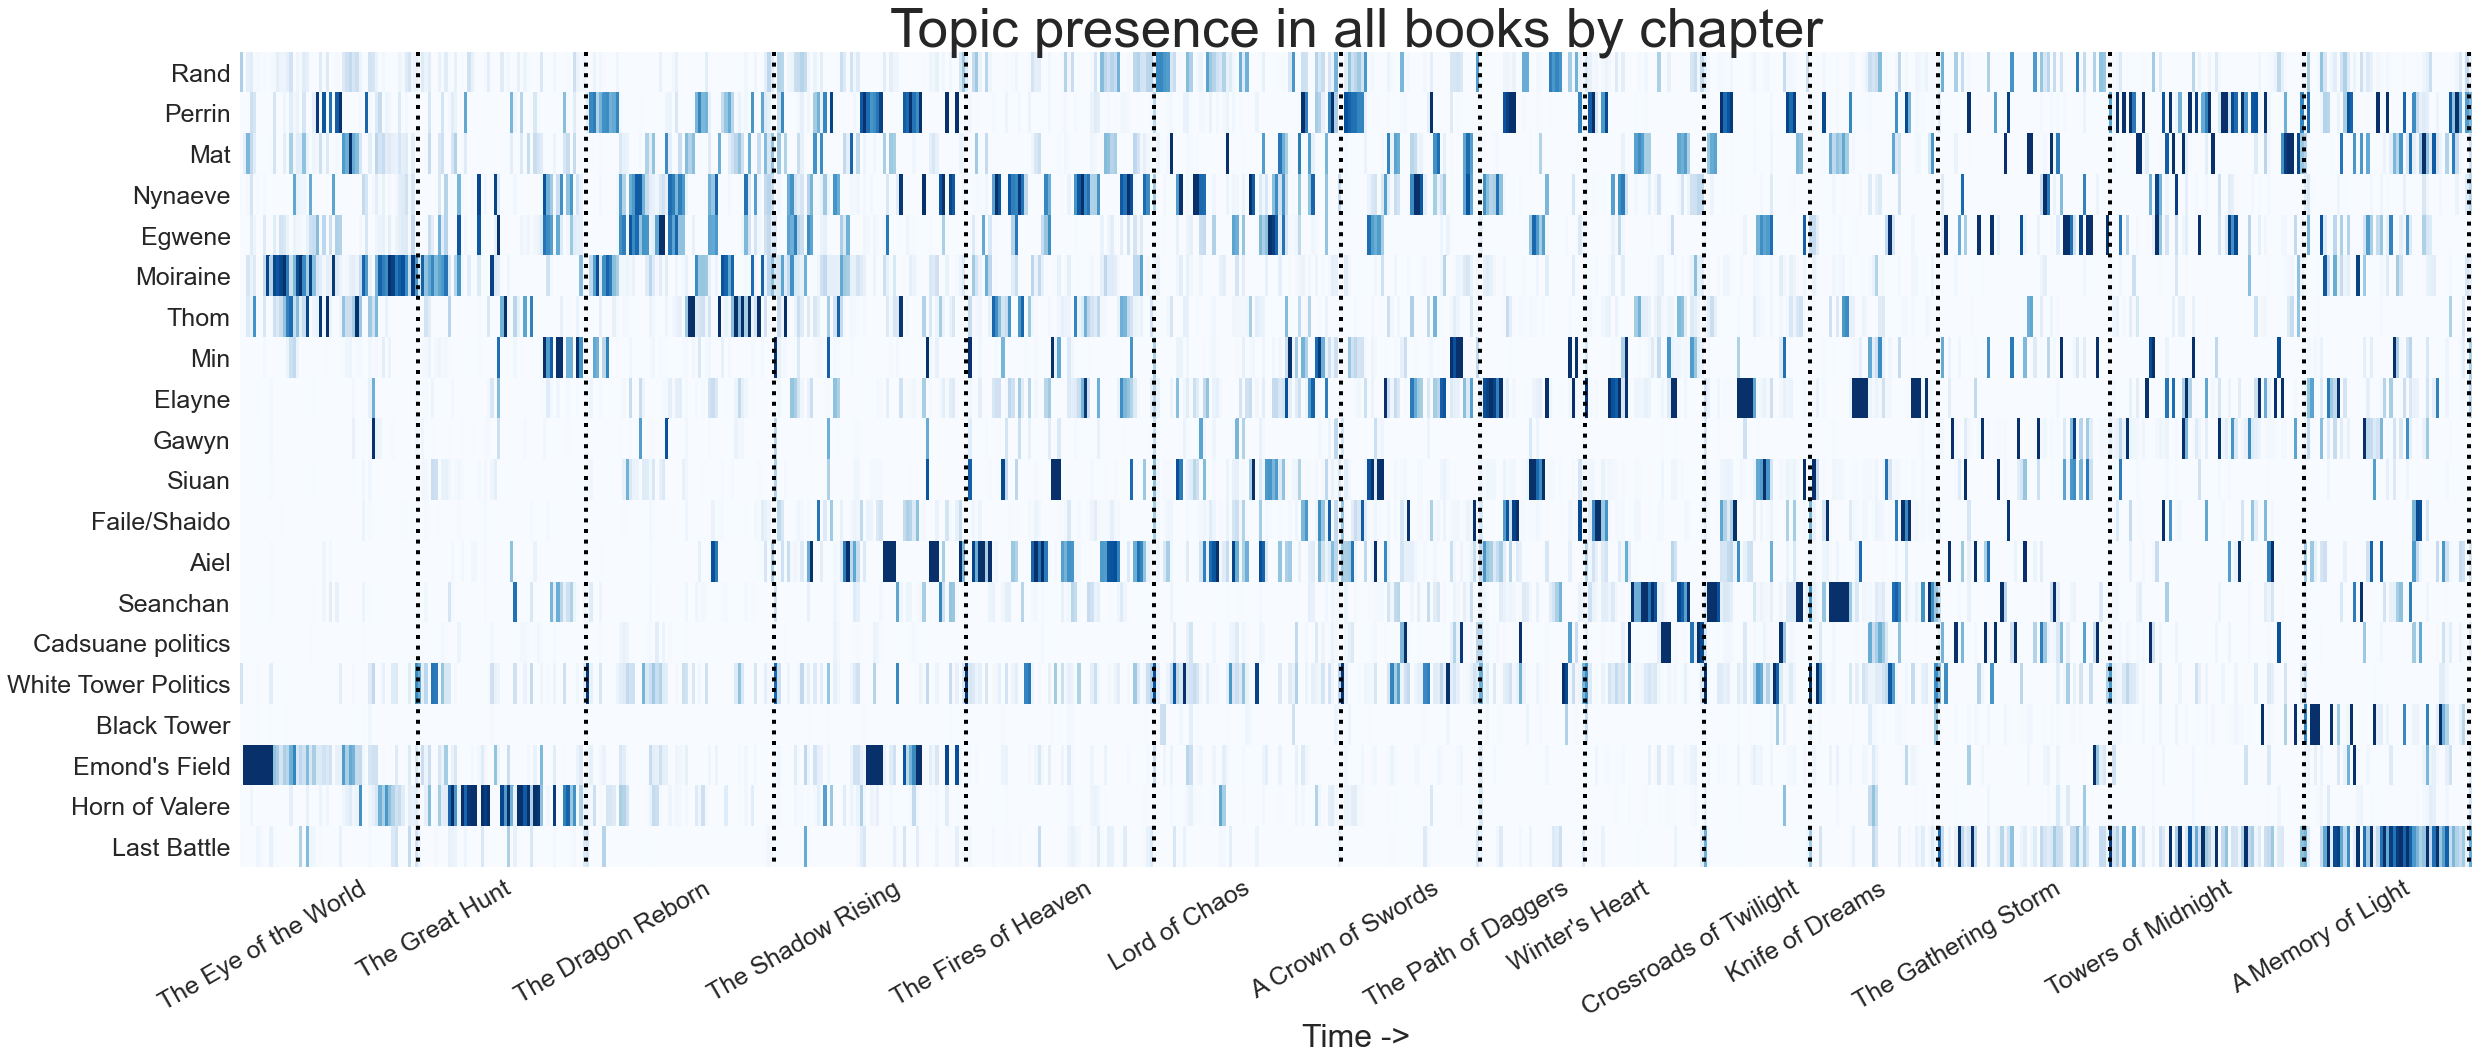

In [28]:
reordered_topics = ['Rand', 'Perrin', 'Mat', 'Nynaeve', 'Egwene','Moiraine','Thom','Min','Elayne', 'Gawyn', 'Siuan',
                    'Faile/Shaido', 'Aiel','Seanchan','Cadsuane politics',  'White Tower Politics','Black Tower', 'Emond\'s Field','Horn of Valere', 'Last Battle']


plt.figure(figsize=(40,15))
sns.heatmap(data = topics_by_chapter[topics].T.reindex(reordered_topics), cmap='Blues', cbar=False, robust=True)
plt.yticks(fontsize=25)
plt.xticks(ticks = tick_locations-20, labels = titles, fontsize = 25, rotation = 30 )
plt.vlines(ends, 0 ,25, color = 'black', linestyles='dotted', linewidths=4)
plt.title('Topic presence in all books by chapter', fontsize = 55)
plt.xlabel('Time ->', fontsize = 32)
plt.show()

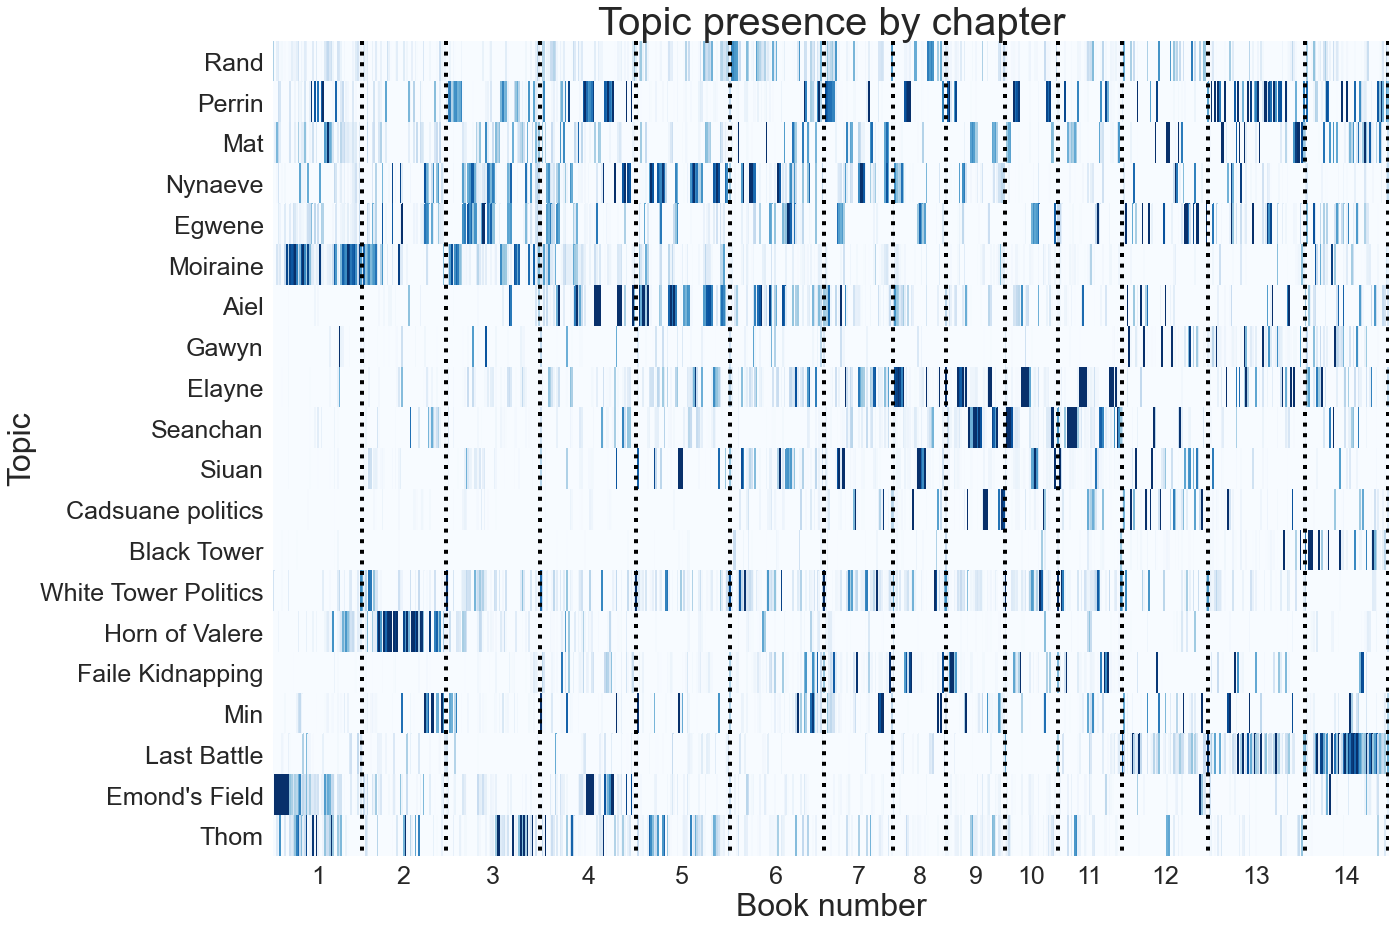

In [18]:
plt.figure(figsize=(20,15))
sns.heatmap(data = topics_by_chapter[topics].T, cmap='Blues', cbar=False, robust=True)
plt.yticks(fontsize=25)
plt.xticks(ticks = tick_locations, labels = np.arange(1,15), fontsize = 25,rotation = 'horizontal')
plt.vlines(ends, 0 ,25, color = 'black', linestyles='dotted', linewidths=4)
plt.title('Topic presence by chapter', fontsize = 40)
plt.ylabel('Topic', fontsize = 32)
plt.xlabel('Book number', fontsize = 32)
plt.show()

In [11]:
np.arange(1,15)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

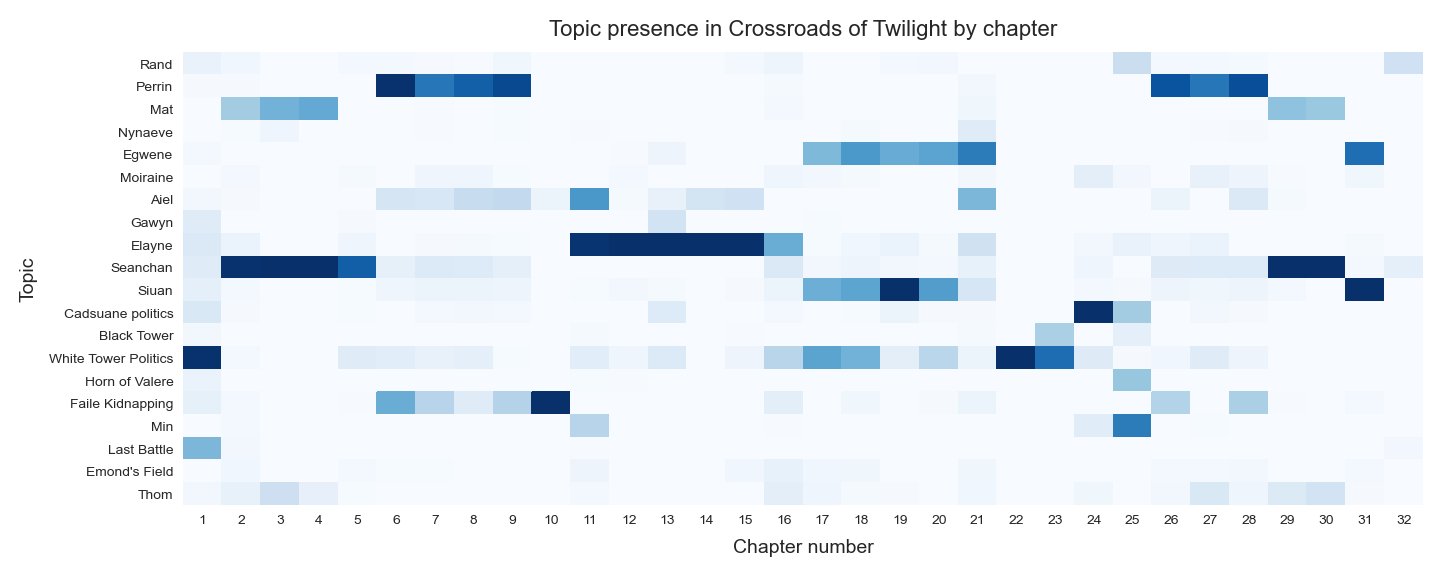

In [26]:
plot_chapter_topics_book(topics_by_chapter, 10)

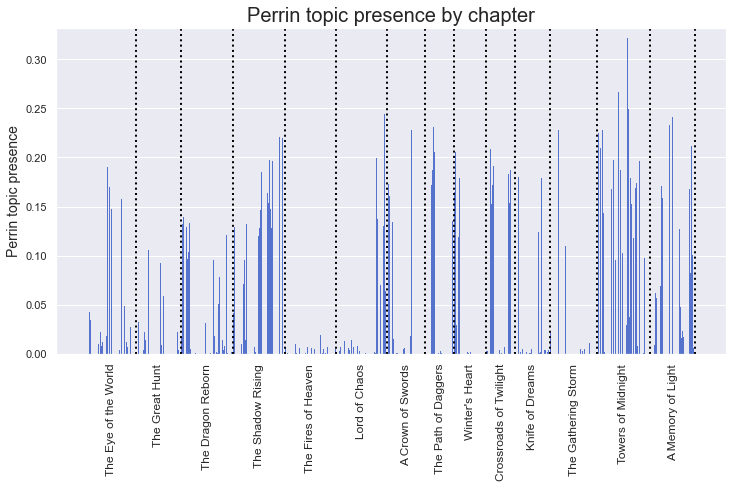

In [62]:
plot_topic_time(topics_by_chapter, 'Perrin')

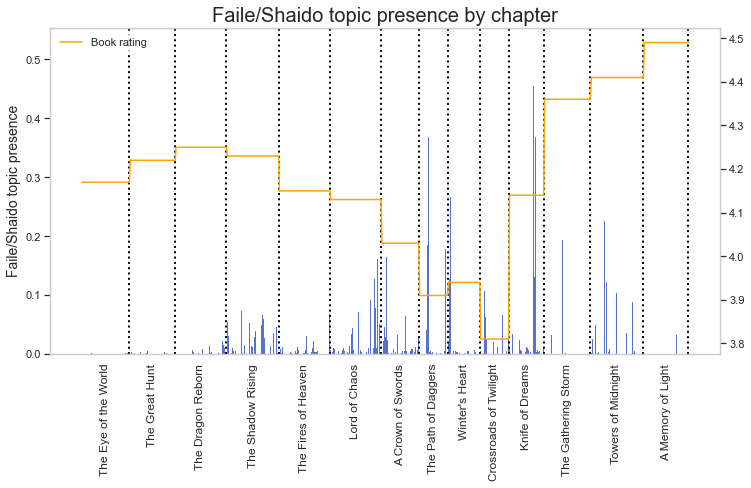

In [79]:
plot_topic_and_rating(topics_by_chapter, 'Faile/Shaido')

Argmax labels

In [29]:
main_topic = [topics[i] for i in np.argmax(doc_topic, axis=1)]

In [30]:
topics_by_chapter['main_topic'] = main_topic

In [31]:
topic_numbers = topics_by_chapter.groupby(['main_topic'])[['Aiel']].count()\
                                                                    .reset_index()\
                                                                    .rename(columns={'Aiel':'num_chapters'})\
                                                                    .sort_values('num_chapters', ascending=False)

How many chapters are concentrated on each topic

In [32]:
sns.set_context('poster')

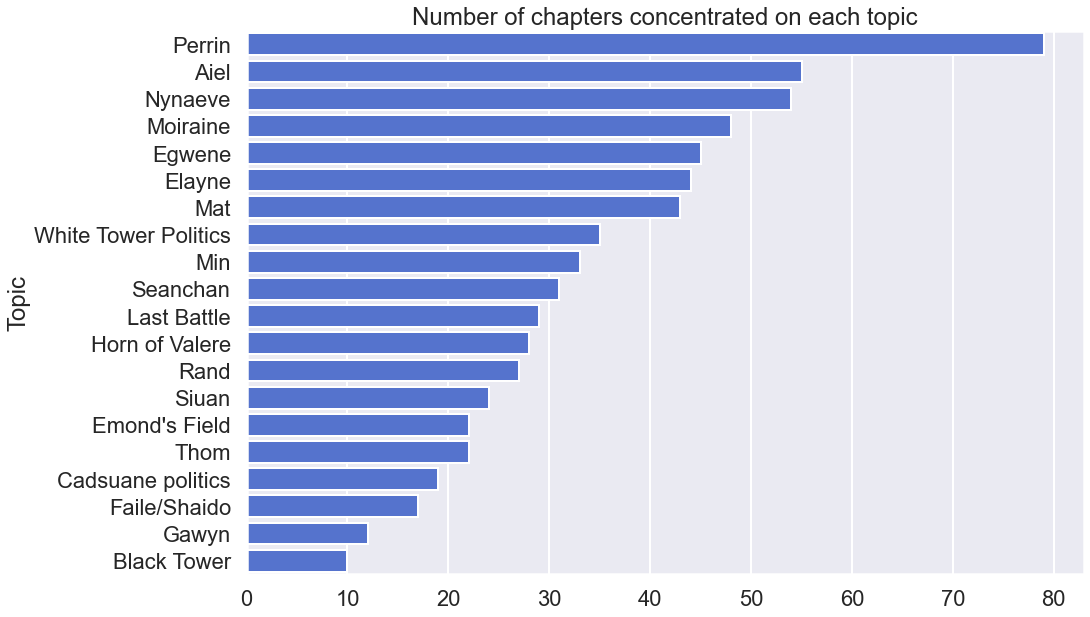

In [33]:
plt.figure(figsize=(15,10))
sns.barplot(data = topic_numbers, y = 'main_topic', x = 'num_chapters', color='royalblue', dodge=False)
plt.ylabel('Topic')
plt.title('Number of chapters concentrated on each topic')
plt.xlabel('')
plt.show()

A bit surprising that Perrin and the Aiel are at the top, and Rand is so far down. Let's look at if any words appear heavily in multiple topics.

In [41]:
word_dict = defaultdict(int)

In [42]:
feature_names= vectorizer.get_feature_names()
for topic in nmf_model.components_:
    top_indices = topic.argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_indices]
    for feature in top_features:
        word_dict[feature]+=1

In [43]:
feature_appearances=pd.DataFrame(list(word_dict.items()),columns = ['feature','num_top10'])\
                                .sort_values('num_top10',ascending=False)


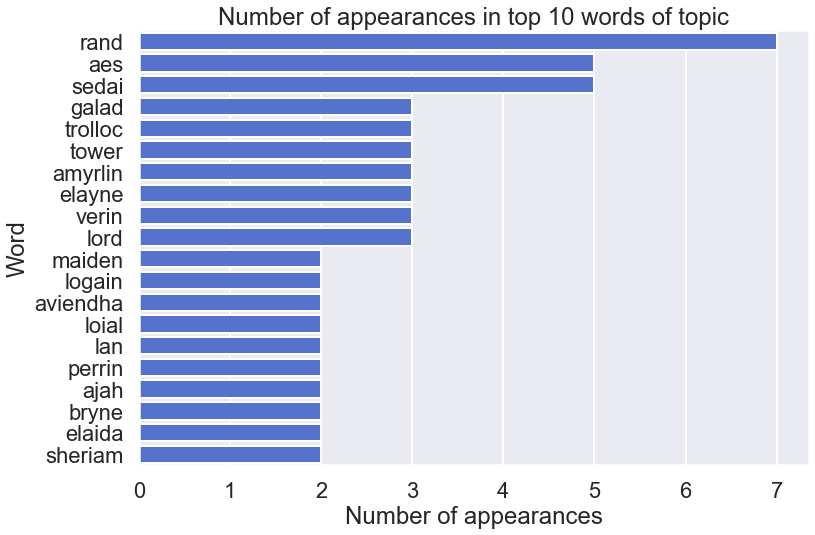

In [77]:
plt.figure(figsize = (12,8))
sns.barplot(data=feature_appearances[:20], y='feature', x='num_top10', color='royalblue')
plt.title('Number of appearances in top 10 words of topic')
plt.ylabel('Word')
plt.xlabel('Number of appearances')
plt.show()

In [25]:
topics_by_chapter.to_pickle('saved_models/topics_by_chapter.pkl')

## Clustering

MeanShift

In [21]:
ms = MeanShift(max_iter = 10000)

In [22]:
ms_labels = ms.fit_predict(doc_topic )

In [23]:
np.unique(ms_labels)

array([0])

Kmeans 

In [40]:
ss = StandardScaler()
doc_topic_scaled = ss.fit_transform(doc_topic)

In [41]:
km = KMeans(n_clusters = 5, max_iter = 10000, random_state = 1)

In [42]:
km_labels = km.fit_predict(doc_topic_scaled)

In [43]:
topics_by_chapter['km_labels'] = km_labels


In [44]:
for i in range(5):
    print(f'Cluster {i}')
    print(topics_by_chapter[topics_by_chapter['km_labels']==i]['main_topic'].value_counts())
    print(sum(list(topics_by_chapter[topics_by_chapter['km_labels']==i]['main_topic'].value_counts())))
    print('*'*50)


Cluster 0
Elayne         44
Nynaeve        35
Thom            5
Mat             2
Moiraine        1
Last Battle     1
Min             1
Aiel            1
Name: main_topic, dtype: int64
90
**************************************************
Cluster 1
Perrin           68
Faile/Shaido     17
Last Battle      11
Emond's Field     8
Black Tower       1
Seanchan          1
Name: main_topic, dtype: int64
106
**************************************************
Cluster 2
Moiraine                47
Aiel                    46
White Tower Politics    31
Horn of Valere          28
Rand                    27
Min                     25
Cadsuane politics       19
Emond's Field           13
Last Battle             12
Perrin                  10
Nynaeve                  7
Black Tower              7
Mat                      4
Thom                     3
Siuan                    2
Seanchan                 1
Egwene                   1
Name: main_topic, dtype: int64
283
*****************************************

In [45]:
for i in range(5):
    print(f'Cluster {i}')
    print(topics_by_chapter[topics_by_chapter['km_labels']==i]['book_title'].value_counts())
    print('*'*50)

Cluster 0
The Fires of Heaven       19
A Crown of Swords         10
The Shadow Rising          9
Winter's Heart             9
Knife of Dreams            9
The Path of Daggers        8
Lord of Chaos              7
Crossroads of Twilight     6
Towers of Midnight         6
The Dragon Reborn          3
A Memory of Light          2
The Gathering Storm        1
The Great Hunt             1
Name: book_title, dtype: int64
**************************************************
Cluster 1
Towers of Midnight        23
The Shadow Rising         18
A Memory of Light         15
Crossroads of Twilight     8
A Crown of Swords          7
Knife of Dreams            7
Winter's Heart             6
The Path of Daggers        6
The Eye of the World       6
Lord of Chaos              4
The Gathering Storm        3
The Dragon Reborn          3
Name: book_title, dtype: int64
**************************************************
Cluster 2
The Great Hunt            40
The Eye of the World      39
The Fires of Heaven    

In [46]:
km_clusters = {0:'Elayne/Nynaeve', 1:'Perrin', 2:'Rand/Main story' , 3:'Egwene', 4:'Mat'}
topics_by_chapter['km_labels_text']=topics_by_chapter['km_labels'].map(km_clusters)

In [56]:
def plot_tSNE(topics_by_chapter, hue_col, palette = 'Set1'):
    ss = StandardScaler()
    tsne_model = TSNE(n_components=2, random_state=1, metric = 'cosine')
    tsne_coords = tsne_model.fit_transform(ss.fit_transform(topics_by_chapter[topics]))
    viz_df = pd.DataFrame(tsne_coords, columns = ['x', 'y'])
    viz_df['hue'] = topics_by_chapter[hue_col]
    plt.figure(figsize = (15,15))
    sns.scatterplot(data = viz_df, x='x', y='y', hue='hue', palette = palette)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(title='Cluster')
    #plt.legend(title='Topic')
sns.set_context('notebook')

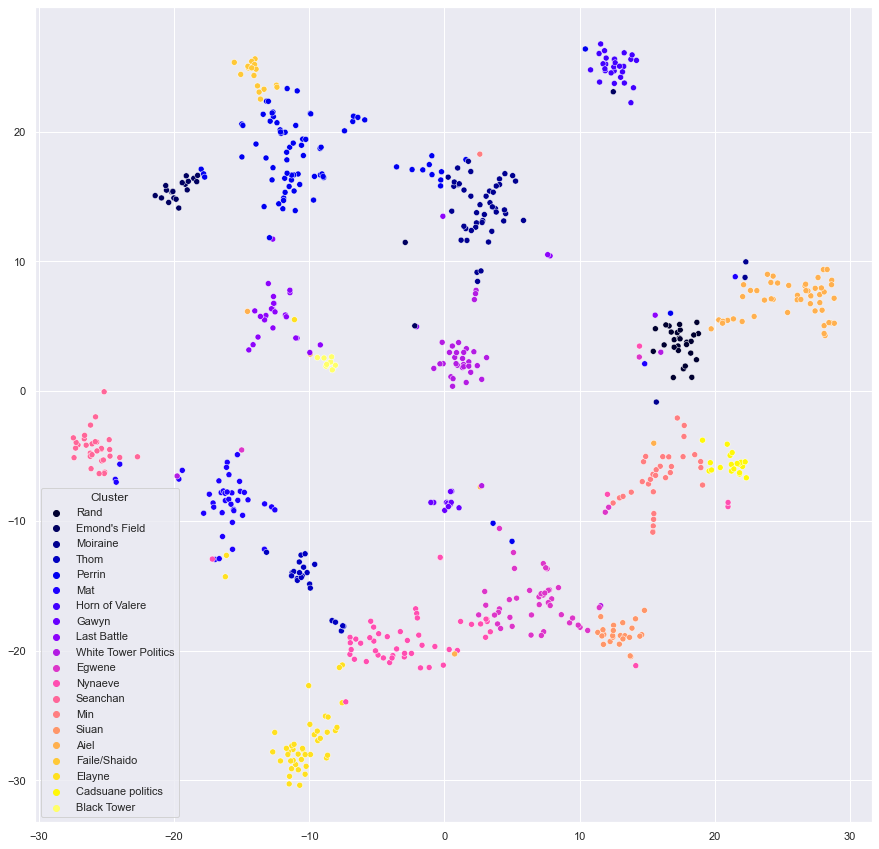

In [57]:
plot_tSNE(topics_by_chapter,'main_topic', palette = sns.color_palette('gnuplot2',20))

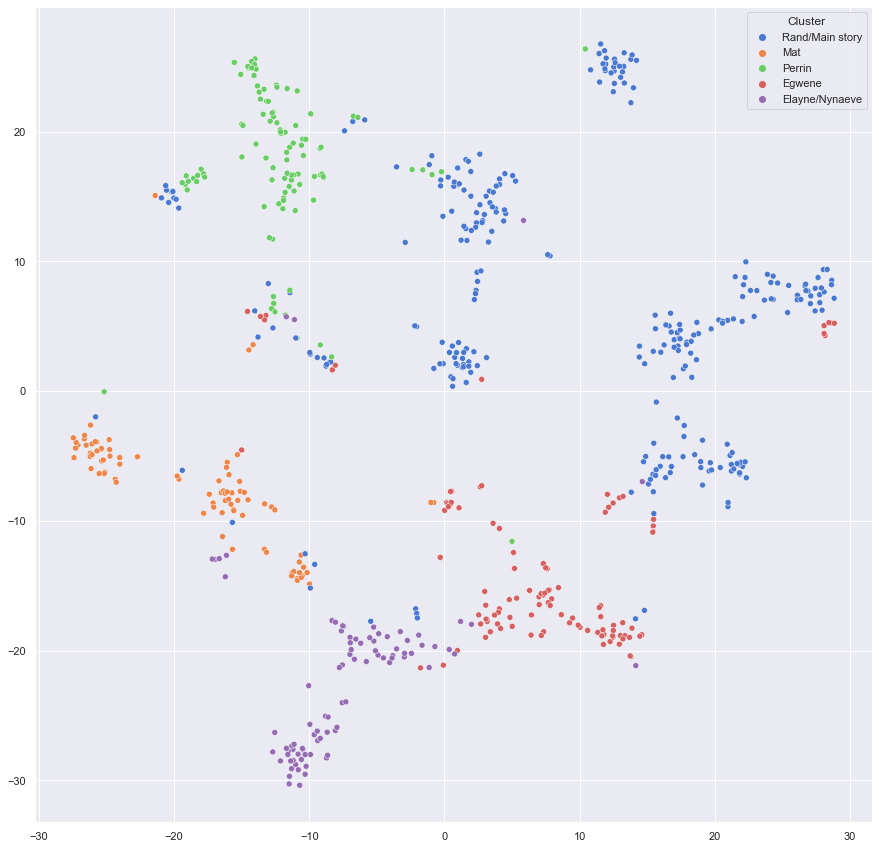

In [58]:
plot_tSNE(topics_by_chapter,'km_labels_text', palette=sns.color_palette('muted', 5))

## Correlation between topics and ratings

In [34]:
ratings = [4.17, 4.22, 4.25, 4.23,4.15,4.13, 4.03, 3.91, 3.94, 3.81, 4.14, 4.36, 4.41, 4.49]

book_titles = topics_by_chapter['book_title'].unique()

rating_dict = {}
for book,rating in zip(book_titles,ratings):
    rating_dict[book] = rating

topics_by_chapter['book_rating'] = topics_by_chapter['book_title'].map(rating_dict)

In [35]:
rating_correlations = topics_by_chapter[topics+['book_rating']].corr()[['book_rating']]

rating_correlations=rating_correlations.reset_index()\
                                .rename(columns={'index':'Topic', 'book_rating': 'Correlation'})\
                                .sort_values(by='Correlation', ascending=False).iloc[1:]

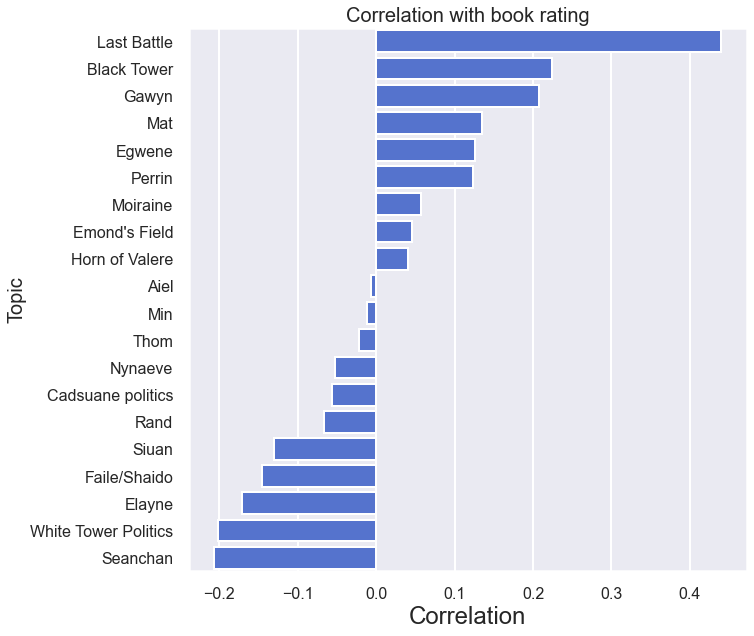

In [36]:
plt.figure(figsize=(10,10))
sns.barplot(data=rating_correlations, y='Topic', x='Correlation', color='royalblue', dodge=False)
plt.xticks(fontsize = 16)
plt.yticks(fontsize=16)
plt.ylabel('Topic', fontsize = 20)
plt.title('Correlation with book rating', fontsize = 20)
plt.xlabel('Correlation')
plt.show()

Some things to be expected here, like the last battle being correlated with the book rating (happens in the last few books, those are all rated highly. BUt there are some weird results, like Gawyn being so high up. I think thats because I've lost some granularity here. The Gawyn heavy books just happend to be some of the better books, so while he might be the worst part of those books, the books overall are viewed as good

## Sentiment analysis

In [29]:
sentiment_df = all_books_nosw_singularized.copy()

In [30]:
sentiment_df

,chapter_title,book_title,cumulative_chapter_number,text
0,Dragonmount,The Eye of the world,1,palace still shook occasionally earth rumbled ...
1,An Empty Road,The Eye of the world,2,wheel time turn age come pas leaving memory be...
2,Strangers,The Eye of the world,3,rand mat carried first barrel common room mast...
3,The Peddler,The Eye of the world,4,cluster pot clattered banged wagon rumbled hea...
4,The Gleeman,The Eye of the world,5,door inn banged shut behind whitehaired spun a...
...,...,...,...,...
672,To Awaken,A Memory of Light,673,rand broke free darknes entered pattern fully ...
673,Watching the Flow Writhe,A Memory of Light,674,fought barely forsaken leaned rock ledge short...
674,A Brilliant Lance,A Memory of Light,675,many dead hundred thousand man trolloc lying p...
675,Light and Shadow,A Memory of Light,676,beneath emptines wolf dream consumed perrin co...


In [35]:
sia = SentimentIntensityAnalyzer()

In [38]:
sentiment_df['sentiment_dict'] = sentiment_df['text'].progress_apply(lambda x: sia.polarity_scores(x))

  0%|          | 0/677 [00:00<?, ?it/s]

In [40]:
sentiment_df['compound'] = sentiment_df['sentiment_dict'].apply(lambda x: x['compound'])

In [41]:
sentiment_df

,chapter_title,book_title,cumulative_chapter_number,text,sentiment_dict,compound
0,Dragonmount,The Eye of the world,1,palace still shook occasionally earth rumbled ...,"{'neg': 0.183, 'neu': 0.676, 'pos': 0.141, 'co...",-0.9950
1,An Empty Road,The Eye of the world,2,wheel time turn age come pas leaving memory be...,"{'neg': 0.101, 'neu': 0.766, 'pos': 0.133, 'co...",0.9987
2,Strangers,The Eye of the world,3,rand mat carried first barrel common room mast...,"{'neg': 0.075, 'neu': 0.798, 'pos': 0.127, 'co...",0.9993
3,The Peddler,The Eye of the world,4,cluster pot clattered banged wagon rumbled hea...,"{'neg': 0.135, 'neu': 0.723, 'pos': 0.142, 'co...",0.9624
4,The Gleeman,The Eye of the world,5,door inn banged shut behind whitehaired spun a...,"{'neg': 0.114, 'neu': 0.722, 'pos': 0.164, 'co...",0.9994
...,...,...,...,...,...,...
672,To Awaken,A Memory of Light,673,rand broke free darknes entered pattern fully ...,"{'neg': 0.208, 'neu': 0.688, 'pos': 0.104, 'co...",-0.9996
673,Watching the Flow Writhe,A Memory of Light,674,fought barely forsaken leaned rock ledge short...,"{'neg': 0.185, 'neu': 0.686, 'pos': 0.129, 'co...",-0.9954
674,A Brilliant Lance,A Memory of Light,675,many dead hundred thousand man trolloc lying p...,"{'neg': 0.143, 'neu': 0.621, 'pos': 0.235, 'co...",0.9926
675,Light and Shadow,A Memory of Light,676,beneath emptines wolf dream consumed perrin co...,"{'neg': 0.193, 'neu': 0.676, 'pos': 0.132, 'co...",-0.9953


<AxesSubplot:xlabel='cumulative_chapter_number', ylabel='compound'>

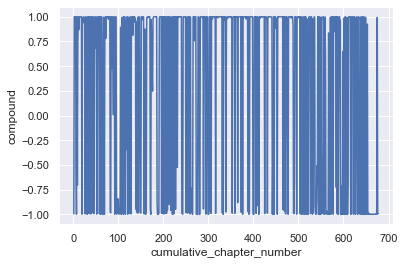

In [42]:
sns.lineplot(data = sentiment_df, x = 'cumulative_chapter_number', y='compound')

Looks like sentiment analysis might not be the best here, since it's more meant for sentences and chapters can get quite long. I might go back and do this for the last battle chapter only, for example

### Sentiment analysis of The Last Battle

In [85]:
with open('books/last_battle.txt', 'r') as f:
        last_battle = f.read()

In [86]:
last_battle = ' '.join(last_battle.split())
last_battle = re.sub('[‘’“”…▼—]', '', last_battle)
lb_sentences = last_battle.split('.')

In [87]:
cleaned_sentences = []
for sentence in lb_sentences:
    if len(sentence) >= 175:
        cleaned_sentences.append(sentence)
lb_sentences = cleaned_sentences

In [89]:
sia = SentimentIntensityAnalyzer()
sentiment_dicts = [sia.polarity_scores(sentence) for sentence in lb_sentences]

In [90]:
compound_scores = np.array([d['compound'] for d in sentiment_dicts])

In [91]:
compound_scores

array([-0.8519, -0.2023, -0.0859, -0.1779, -0.5106,  0.4754,  0.5949,
       -0.3818, -0.5233, -0.6821, -0.8979,  0.7506, -0.775 , -0.8156,
        0.    , -0.3818,  0.0258, -0.2732, -0.2023, -0.466 , -0.4767,
       -0.9399,  0.0772, -0.4019,  0.    , -0.4184, -0.3716, -0.4854,
       -0.7941,  0.    , -0.0516, -0.7271, -0.5451, -0.4588,  0.8074,
       -0.6249,  0.8248, -0.5994, -0.8168, -0.9294,  0.    , -0.6329,
       -0.7901, -0.5859, -0.3307, -0.8122, -0.7184,  0.    , -0.2023,
        0.5255,  0.9371, -0.7153, -0.8506, -0.5007,  0.3085, -0.3612,
       -0.4939, -0.9126, -0.34  , -0.906 ,  0.1759,  0.7399,  0.4404,
       -0.6705,  0.5267,  0.0834,  0.    ,  0.    , -0.3182,  0.4003,
       -0.6662, -0.1606, -0.1511, -0.6486,  0.    , -0.296 ,  0.3612,
       -0.6858, -0.9129, -0.7263, -0.7156, -0.296 , -0.3802, -0.7219,
        0.1007, -0.8478, -0.9153, -0.6124, -0.905 ,  0.    , -0.0891,
        0.0981,  0.3182,  0.2732,  0.7081, -0.5106, -0.8834, -0.4795,
       -0.2732,  0. 

<AxesSubplot:>

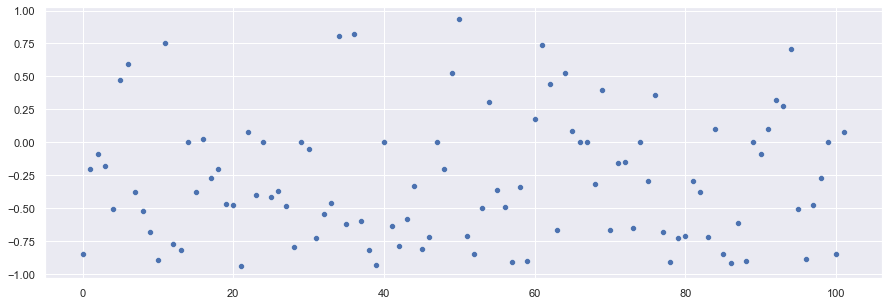

In [92]:
plt.figure(figsize = (15,5))
sns.scatterplot(x = np.arange(len(compound_scores)), y=compound_scores)

Seems like this didnt really work either 

In [115]:
a=np.array([[1,2,3,4,10],[4,10,20,1,3]])